In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
words = open('../names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


Convolutoin basics

In [ ]:
emb = torch.randn((vocab_size, 2))
emb.shape

torch.Size([27, 2])

In [ ]:
x, y = Xtr[:1], Ytr[:1]
x, y

(tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), tensor([25]))

In [ ]:
x_emb = emb[x]
x_emb.shape

torch.Size([1, 8, 2])

In [ ]:
x_emb = x_emb.view(1, 4, 4)
x_emb.shape

torch.Size([1, 4, 4])

In [ ]:
c = nn.Conv1d(4, 4,  kernel_size=3, stride=2, padding=1)
x_intr = c(x_emb)
x_intr.shape

torch.Size([1, 4, 2])

In [ ]:
x_intr = x_intr.view(1, 2, 4)
x_intr.shape

torch.Size([1, 2, 4])

In [ ]:
c = nn.Conv1d(2, 2,  kernel_size=3, stride=2, padding=1)

x_intr = c(x_intr)
x_intr.shape

torch.Size([1, 2, 2])

In [ ]:
x_intr = x_intr.view(1, 1, 4)
x_intr.shape

torch.Size([1, 1, 4])

In [ ]:
c = nn.Conv1d(1, 1,  kernel_size=3, stride=2, padding=1)

x_intr = c(x_intr)
x_intr.shape

torch.Size([1, 1, 2])

In [ ]:
for p in c.parameters():
    print(p)

Parameter containing:
tensor([[[-0.4797, -0.2000, -0.0679]]], requires_grad=True)
Parameter containing:
tensor([0.0914], requires_grad=True)


In [ ]:
n_embd = 32 # the dimensionality of the character embedding vectors
n_hidden = 200
n_iters = 20_000
bs = 256

In [ ]:
emb =  nn.Embedding(vocab_size, n_embd)
x = emb(Xtr)
x.shape, x.view(x.shape[0], 8//2, 32*2).shape

(torch.Size([182625, 8, 32]), torch.Size([182625, 4, 64]))

In [ ]:
def conv(ni, nf, k=3, s=1):
    layer = [nn.Conv1d(ni, nf,  kernel_size=k, stride=s, padding=(k-1)//2)]
    layer.append(nn.BatchNorm1d(nf))
    
    return nn.Sequential(*layer)
    
def block(ni, nf, k=3, non_linear='tanh'):

    layer = [conv(ni, nf,  k=1)]
    non_linear = nn.Tanh() if non_linear == 'tanh' else nn.Sigmoid()
    layer.append(non_linear)
    layer.append(conv(nf, nf,  k=k, s=2))
    
    return nn.Sequential(*layer)

In [ ]:
class FlattenConsecutive:
    def __init__(self, n):
        #super(FlattenConsecutive, self).__init__()
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        return x

In [ ]:
f = FlattenConsecutive(2)
t = torch.randn((182625,2, 64))
f(t).shape, f(t).squeeze(1).shape

(torch.Size([182625, 1, 128]), torch.Size([182625, 128]))

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.emb = nn.Embedding(vocab_size, n_embd)
        self.b1 = block(4, 4, k=7)
        self.b2 = block(2, 2, k=7)
        self.b3 = block(1, 2, k=7)
        self.flat = FlattenConsecutive(2)
        self.ln1 = nn.Linear(n_embd*2, n_hidden)
        self.ln2 = nn.Linear(n_hidden, vocab_size)
        
        
        
    def forward(self, x):
        
        x = self.emb(x)                     # bs * block_size * n_embd
        #print("emb -> ", x.shape)
        x = self.flat(x)                    # bs * block_size//2 * n_embd * 2
        #print("flatten1 -> ",x.shape)
        x = self.b1(x)                      # bs * block_size//2 * n_embd 
        #print("b1 -> ", x.shape)
        x = self.flat(x)                    # bs * block_size//4 * n_embd * 2
        #print("flatten2 -> ",x.shape)
        x = self.b2(x)                      # bs * block_size//4 * n_embd 
        #print("b2 -> ",x.shape)
        x = self.flat(x)                    # bs * block_size//8 * n_embd * 2
        #print("flatten3 -> ",x.shape)
        x = self.b3(x).view(-1, n_embd*2)              #.squeeze(1)           # bs * n_embd 
        #print("b3 -> ",x.shape)
        x = self.ln2((self.ln1(x)).tanh())
        return x
model = CNN()
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
model

19529


CNN(
  (emb): Embedding(27, 32)
  (b1): Sequential(
    (0): Sequential(
      (0): Conv1d(4, 4, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Tanh()
    (2): Sequential(
      (0): Conv1d(4, 4, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (b2): Sequential(
    (0): Sequential(
      (0): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Tanh()
    (2): Sequential(
      (0): Conv1d(2, 2, kernel_size=(7,), stride=(2,), padding=(3,))
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (b3): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 2, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
x = model(Xtr)
x.shape

torch.Size([182625, 27])

In [ ]:
loss = F.cross_entropy(x, Ytr)
loss

tensor(3.2987, grad_fn=<NllLossBackward0>)

In [ ]:
lossi = []
for i in range(n_iters):
  ix = torch.randint(0, Xtr.shape[0], (bs,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch
    
  pred = model(Xb)

  loss = F.cross_entropy(pred, Yb)

  # backward pass
  model.zero_grad()
  loss.backward()

  # update
  lr = 0.5 if i < 100000 else 0.001 # step learning rate decay
  with torch.no_grad():
      for p in model.parameters():
        p.data -= lr * p.grad

  if i % 1000 == 0:
    print(f"{i} -> {loss.item():.4f}")

  lossi.append(loss.log10().item())
  #if i >= 1000:
  #  break 

0 -> 3.2917
1000 -> 2.2254
2000 -> 2.3429
3000 -> 2.2011
4000 -> 2.2108
5000 -> 2.1020
6000 -> 2.0349
7000 -> 2.1012
8000 -> 2.0885
9000 -> 2.0838
10000 -> 2.0528
11000 -> 2.1360
12000 -> 2.1320
13000 -> 2.0410
14000 -> 2.2275
15000 -> 1.9916
16000 -> 1.9482
17000 -> 2.1525
18000 -> 2.0752
19000 -> 1.9779


[<matplotlib.lines.Line2D>]

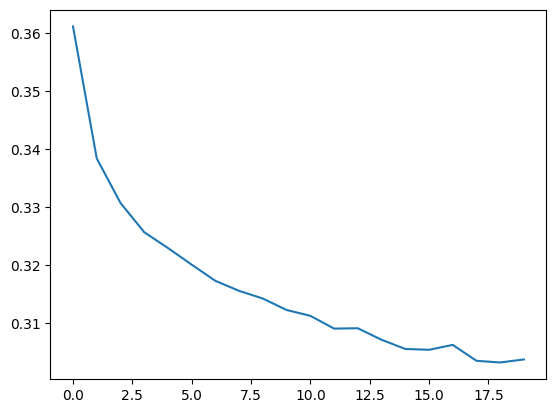

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
@torch.no_grad
def split_loss(split):
        x,y = {
            'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte),
        }[split]
        
        model.eval()
        pred = model(x)
        loss = F.cross_entropy(pred, y)
        print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 2.016251802444458
val 2.112487554550171
test 2.1067183017730713
